In [5]:
!pip install pymysql > /dev/null
!apt-get install -y fonts-nanum > /dev/null
!fc-cache -fv > /dev/null
!rm -rf ~/.cache/matplotlib > /dev/null
# 런타임 다시시작

In [1]:
from google.colab import files
uploaded = files.upload()
filename = list(uploaded.keys())[0]

Saving mysql.json to mysql.json


In [2]:
import json
with open(filename) as fp:
    config_str = fp.read()
config = json.loads(config_str)

In [3]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['axes.unicode_minus'] = False
plt.rc('font', family='NanumBarunGothic')

# 1. 월별 매출/이익

In [10]:
import pymysql

def get_monthly(config):
    conn = pymysql.connect(**config)
    cur = conn.cursor()

    sql = """
        SELECT DATE_FORMAT(sdate, '%m') AS `month`, 
            SUM(revenue) AS revenue, SUM(profit) AS profit
            FROM sales_book
            GROUP BY `month`
            ORDER BY `month`;
    """
    cur.execute(sql)
    results = cur.fetchall()

    cur.close()
    conn.close()
    return results

In [11]:
#results = dm.get_monthly_data(config)
results = get_monthly(config)
df = pd.DataFrame(results, columns=['월','매출','이익'])
df.set_index('월', inplace=True)
df['매출'] = df.매출.astype(int)
df['이익'] = df.이익.astype(int)
df

,매출,이익
월,,
01,22173100,1844170
02,18513300,1551780
03,13898500,965790
04,13762100,1062860
05,13840000,1210940
06,14391300,1273840
07,20522400,2034210
08,22590800,2337050
09,16385400,1660460


In [12]:
tdf = df.T
tdf['계'] = [df.매출.sum(), df.이익.sum()]
tdf

월,01,02,03,04,05,06,07,08,09,10,11,12,계
매출,22173100,18513300,13898500,13762100,13840000,14391300,20522400,22590800,16385400,13838600,20651800,21867900,212435200
이익,1844170,1551780,965790,1062860,1210940,1273840,2034210,2337050,1660460,1230510,1878290,2062950,19112850


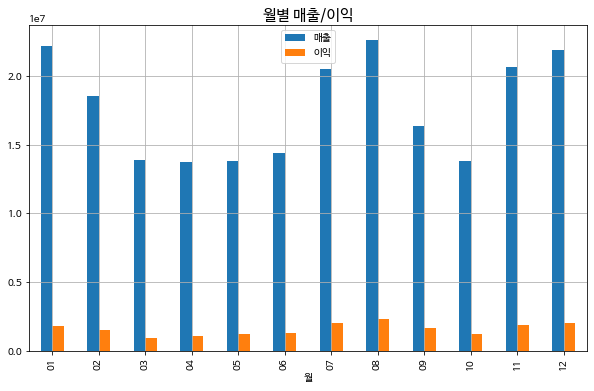

In [13]:
df.plot.bar(figsize=(10,6))
plt.title('월별 매출/이익', size=15)
plt.grid()
plt.show()

# 2. 거래처별 매출/이익

In [14]:
# 소수점 자리 제한을 위한 코드
pd.options.display.float_format = '{:.2}'.format

In [15]:
def get_data_by_company(config):
        conn = pymysql.connect(**config)
        cur = conn.cursor()

        sql="""
            SELECT scompany, SUM(revenue) AS revenue, SUM(profit) AS propit
                FROM sales_book
                GROUP BY scompany
                ORDER BY revenue desc;
        """
        cur. execute(sql)
        results = cur.fetchall()

        cur.close()
        conn.close()
        return results

In [17]:
results = get_data_by_company(config)
df = pd.DataFrame(results, columns=['판매처','매출','이익'])
df.set_index('판매처', inplace=True)
df['매출'] = df.매출.astype(int)
df['이익'] = df.이익.astype(int)
df['이익률'] = df.이익 / df.매출 * 100
df

,매출,이익,이익률
판매처,,,
금성,35555700,3410680,9.6
천왕성,30573700,2941910,9.6
목성,27420700,2049880,7.5
수성,24074500,2399430,1e+01
화성,22744500,1821890,8.0
테크브루,16371300,1524440,9.3
한경아카데미,15358300,1594640,1e+01
멀티캠퍼스,12811400,1186770,9.3
표준협회,11608800,847590,7.3


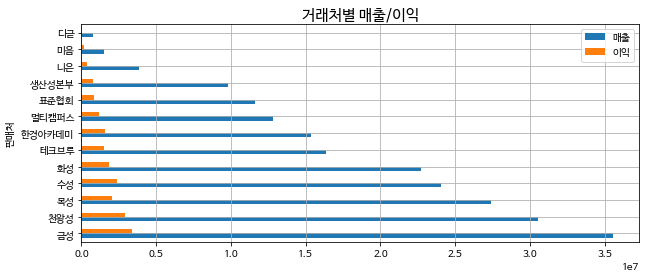

In [19]:
df[['매출','이익']].plot.barh(rot=0, figsize=(10,4))
plt.title('거래처별 매출/이익', size=15)
plt.grid()
plt.show()

# 3. 거래처별 판매상품 및 수량

In [20]:
def get_products_by_company(config):
        conn = pymysql.connect(**config)
        cur = conn.cursor()

        sql="""
            SELECT scompany, pname, SUM(sunit) AS unit
                FROM sales_book
                GROUP BY scompany, pname
                ORDER BY scompany;
        """
        cur. execute(sql)
        results = cur.fetchall()

        cur.close()
        conn.close()
        return results

In [21]:
results = get_products_by_company(config)
df = pd.DataFrame(results, columns=['판매처','상품','수량'])
df.set_index(['판매처','상품'], inplace=True)
df['수량'] = df.수량.astype(int)
df

수량
판매처 상품       
금성   서랍장    2
    거울     14
    공책     10
    베이킹기계  22
    볼펜     18
...        ..
화성  커피머신   18
    티스푼     6
    티코스터   47
    파일     17
    필통      3

[201 rows x 1 columns]

In [22]:
df.reset_index()['판매처'].unique()

array(['금성', '니은', '디귿', '멀티캠퍼스', '목성', '미음', '생산성본부', '수성', '천왕성',
       '테크브루', '표준협회', '한경아카데미', '화성'], dtype=object)

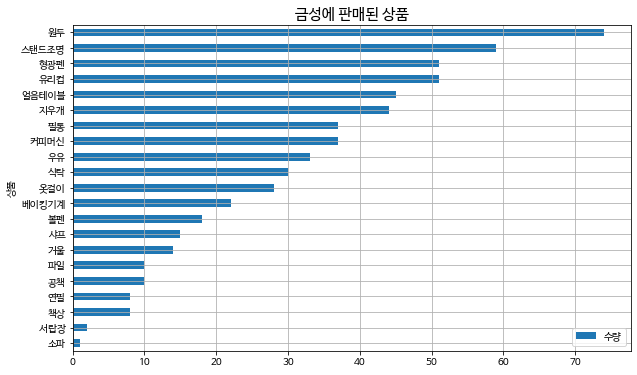

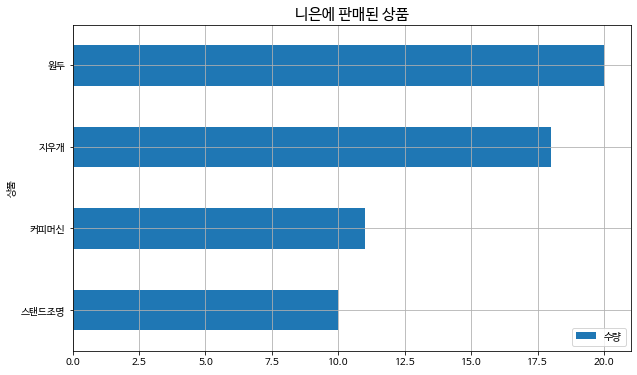

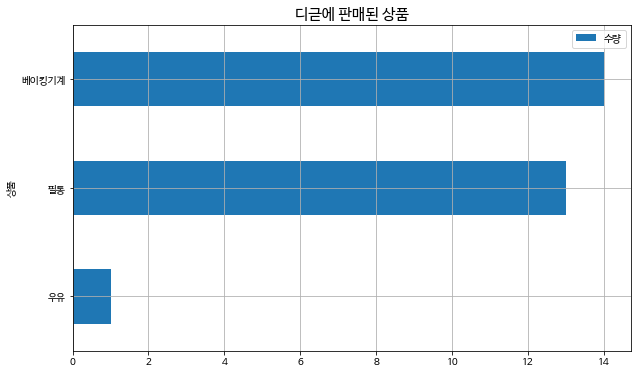

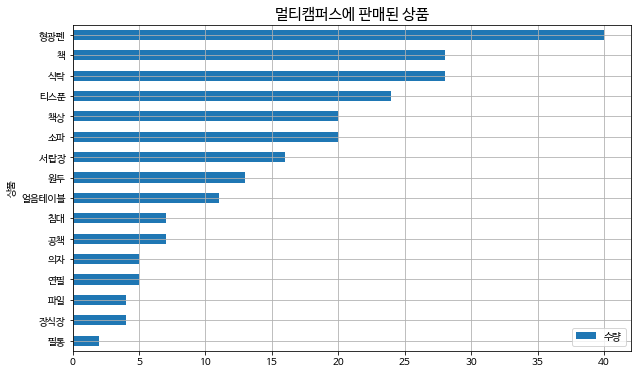

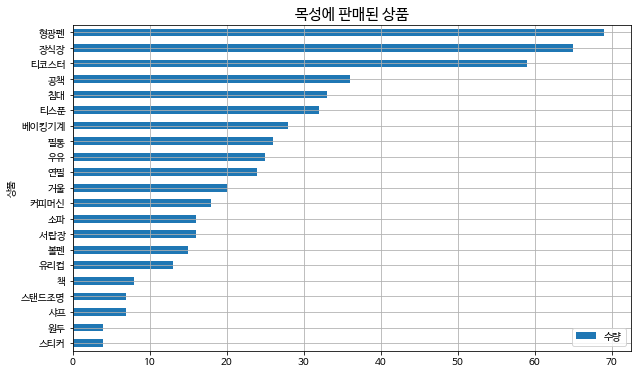

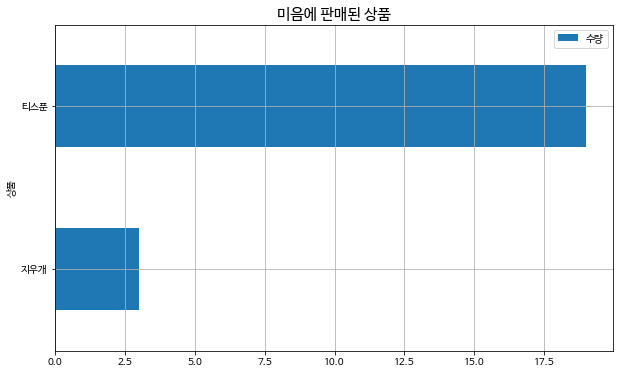

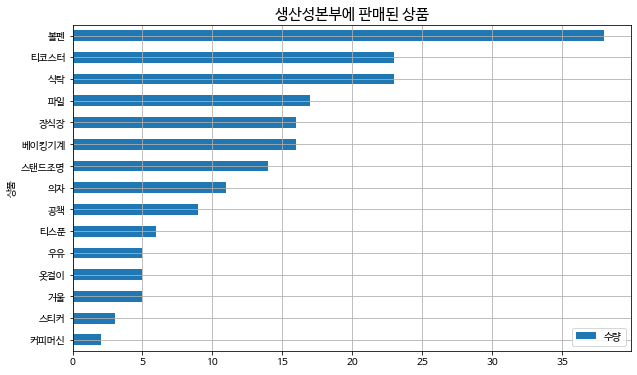

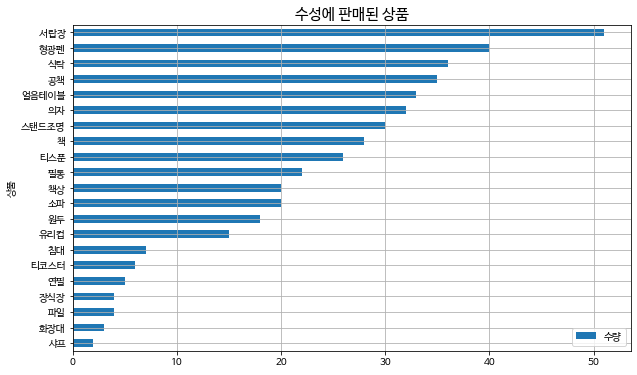

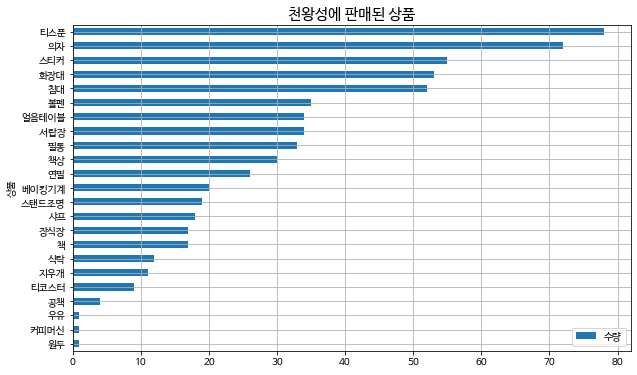

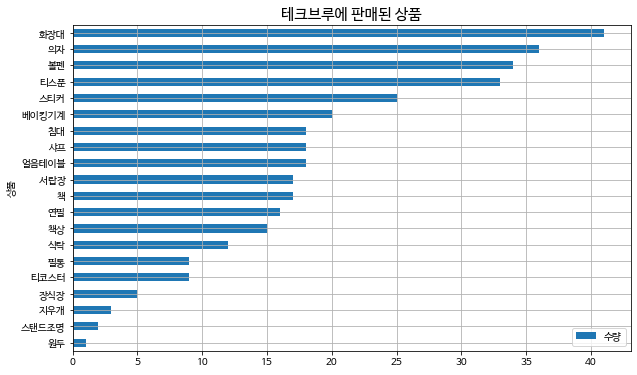

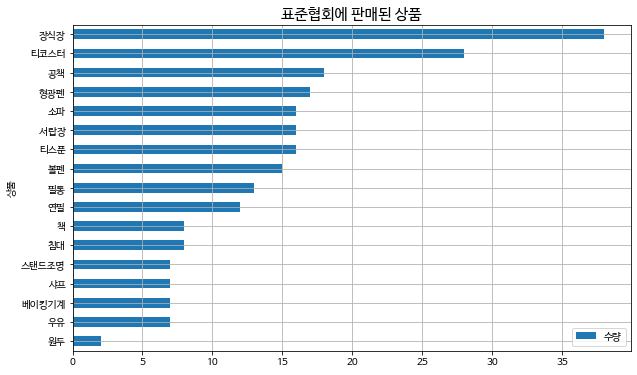

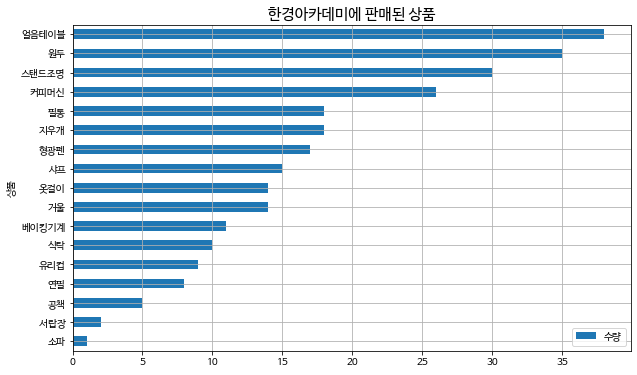

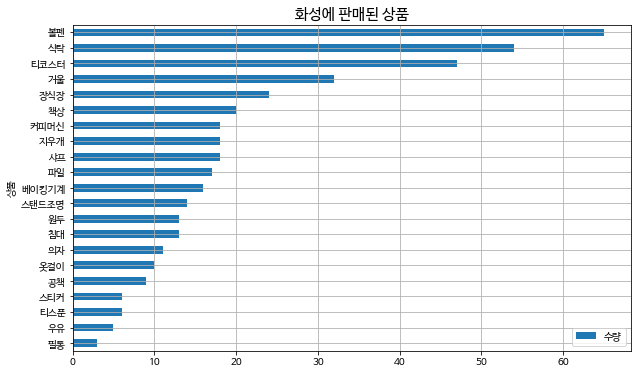

In [23]:
for company in df.reset_index()['판매처'].unique():
    sdf=df.loc[(company,)]
    sdf.sort_values(by='수량').plot.barh(figsize=(10,6))
    plt.title(f'{company}에 판매된 상품', size=15)
    plt.grid()
    plt.show()

# 4. 제품별 판매수량/매출/이익

In [24]:
def get_data_by_products(config):
        conn = pymysql.connect(**config)
        cur = conn.cursor()

        sql="""
            SELECT pname, SUM(sunit) AS unit, SUM(revenue) AS revenue, SUM(profit) AS profit
                FROM sales_book
                GROUP BY pid
                ORDER BY pid;
        """
        cur. execute(sql)
        results = cur.fetchall()

        cur.close()
        conn.close()
        return results

In [25]:
results = get_data_by_products(config)
df = pd.DataFrame(results, columns=['상품','수량','매출','이익'])
df.set_index('상품',inplace=True)
df['수량'] = df.수량.astype(int)
df['매출'] = df.매출.astype(int)
df['이익'] = df.이익.astype(int)
df

,수량,매출,이익
상품,,,
원두,151,4001500,519440
커피머신,113,10723700,1609120
유리컵,88,7576800,1060400
티코스터,181,14280900,571960
티스푼,240,15840000,1742400
베이킹기계,154,2340800,163240
우유,77,7284200,364210
얼음테이블,179,10346200,1448110
의자,167,5076800,303940


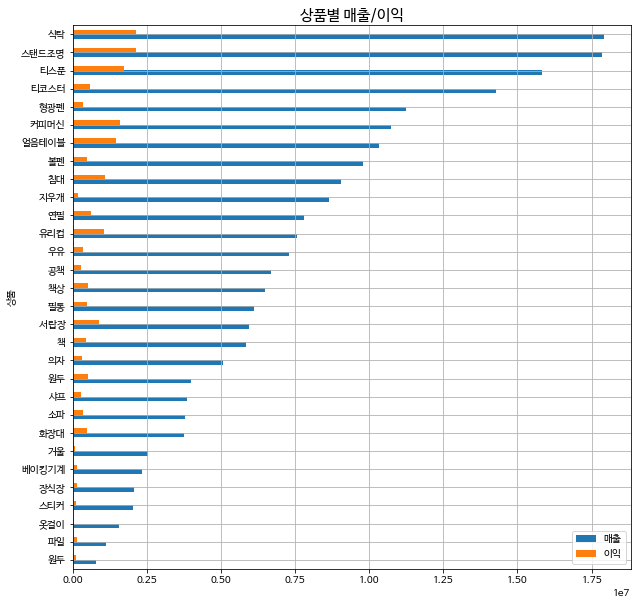

In [26]:
df[['매출','이익']].sort_values(by='매출').plot.barh(rot=0, figsize=(10,10))
plt.title('상품별 매출/이익', size=15)
plt.grid()
plt.show()

# 5. 카테고리별 매출/이익

In [27]:
def get_data_by_category(config):
        conn = pymysql.connect(**config)
        cur = conn.cursor()

        sql="""
            SELECT pcategory, SUM(revenue) AS revenue, SUM(profit) AS profit
                FROM sales_book
                GROUP BY pcategory;
        """
        cur. execute(sql)
        results = cur.fetchall()

        cur.close()
        conn.close()
        return results

In [29]:
results = get_data_by_category(config)
df = pd.DataFrame(results, columns=['카테고리','매출', '이익'])
df.set_index('카테고리',inplace=True)
df['매출'] = df.매출.astype(int)
df['이익'] = df.이익.astype(int)
df['이익률'] = df.이익 / df.매출 * 100
df

,매출,이익,이익률
카테고리,,,
카페용품,78265900,7886020,1e+01
학용품,63200100,3355000,5.3
가구,70969200,7871830,1.1e+01


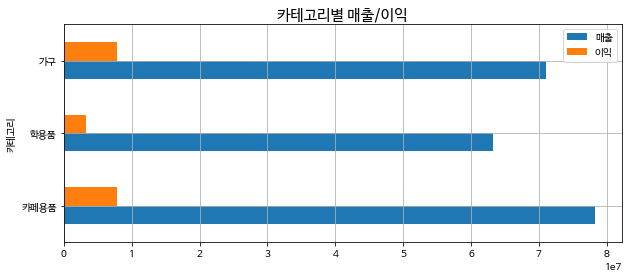

In [30]:
df[['매출','이익']].plot.barh(rot=0, figsize=(10,4))
plt.title('카테고리별 매출/이익', size=15)
plt.grid()
plt.show()

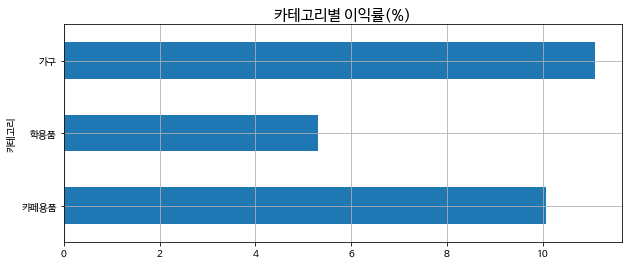

In [33]:
df['이익률'].plot.barh(rot=0, figsize=(10,4))
plt.title('카테고리별 이익률(%)', size=15)
plt.grid()
plt.show()